- Name: Yiwen Shi
- PID: A53100492
- E-mail: yis018@ucsd.edu

## Homework 3 - Extra Credit

### Extra Credit
* Can you figure out what is the reason for these lower counts (especially at the beginning and end of the year and also the sudden dip at the end of each month)? Is it restricted to a subset of the stations? Suggest a way to remove this effect.

* Can you Explain the counts per day for "SNWD" ?

Provide your explanation in new markdown cells appended after this cell. Support your explanation
using code cells and graphs. If you need more data that is available only in the full dataset in the cloud but not in the data you have downloaded, contact your TA.

### Methods
1. collect raw data for measurement "SNWD"
2. Count non-NaN records for for each station each day
3. Calculate standard deviation(std) for number of records of each station
4. Plot for stations with lower std and high std, compare the plots

In [1]:
import os
import sys

from pyspark.sql import SQLContext
from pyspark.sql.types import Row, StructField, StructType, StringType, IntegerType
import numpy as np
import pandas as pd

sqlContext = SQLContext(sc)
sqlContext

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Original data is collected using following code:

Read the original parquet data into pyspark DataFrame

In [3]:
raw = sqlContext.read.load("SYW2.parquet")
raw.registerTempTable("raw")

Count for valid redord for each station for each day in a year

In [4]:
query = "SELECT station"
for i in range(1,366):
    query += ", SUM(CASE WHEN `" + str(i) + "` = 'NaN' THEN 0 ELSE 1 END) cnt" + str(i)
    
query += " FROM raw GROUP BY station"

daily_cnt = sqlContext.sql(query)

Convert pyspark DataFrame into Pandas DataFrame

In [5]:
daily_pd = daily_cnt.toPandas()

Calculate standard deviation for number of records for each station. 

Because lower std implies that the station record weather data regularly, count of records are steady, do not vary a lot, thus should contribute to the staeady part of the count plot for SNWD in part 1. While the stations do not record regularly should contribute to the varies of the count plot for SNWD in part 1.

In [6]:
std = daily_pd.loc[:, 'cnt1':'cnt365'].std(axis=1)
daily_pd['cnt_std'] = std

In [7]:
yearday=[i for i in range(1,366)]

Plot count of records for stations with higher std.

Different between Max Count and Min Count is 44874


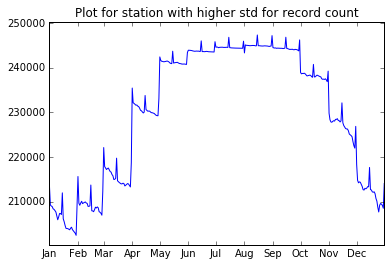

In [8]:
filtered = daily_pd.loc[daily_pd['cnt_std'] > 2.5, :]
cnt_filtered = filtered.loc[:, 'cnt1':'cnt365'].sum()
plt.gca().xaxis.set_major_formatter( DateFormatter('%b') )
plot_date(yearday, cnt_filtered, '-')
title('Plot for station with higher std for record count')
ylim((max(cnt_filtered)-47000, max(cnt_filtered) + 3000))
print 'Different between Max Count and Min Count is ' + str(max(cnt_filtered)-min(cnt_filtered))

Plot count of records for stations with lower std.

Different between Max Count and Min Count is 6939


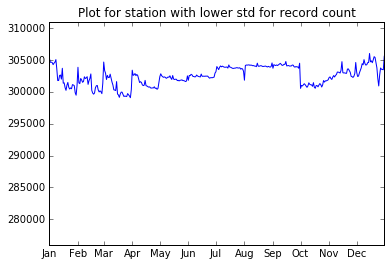

In [9]:
filtered2 = daily_pd.loc[daily_pd['cnt_std'] <= 2.5, :]
cnt_filtered2 = filtered2.loc[:, 'cnt1':'cnt365'].sum()
plt.gca().xaxis.set_major_formatter( DateFormatter('%b') )
plot_date(yearday, cnt_filtered2, '-')
title('Plot for station with lower std for record count')
ylim((max(cnt_filtered2)-30000, max(cnt_filtered2)+5000))
print 'Different between Max Count and Min Count is ' + str(max(cnt_filtered2)-min(cnt_filtered2))

### Solution

As we can see from the count plot in part 1, the maximum and minimum count differs by about 35000.

For stations with lower std, the count plot is very steady, and the difference between maximum and minimum is 6939, relative small compared to 35000.

While for stations with higher std, the count plot varies a lot, and the tendency is similar to count plot for all the stations, the difference between maximum and minimum is 44874.

Thus we can conclude that the the sudden dip is restricted to a subset of stations.

Alternatively, we can drop the years when there are too many NaN numbers, and keep the years when data are more complete. 